<h1 align="center">Volume 4: Inverse Problems.</h1>

    NAME
    Section #
    DATE

In [1]:
from math import sqrt, pi
import numpy as np
from scipy.fftpack import fft, ifft
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def initialize_all(y0, t0, t1, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size),dtype=complex).squeeze()
    else:
        Y = np.empty(n,dtype=complex)
    Y[0] = y0
    T = np.linspace(t0, t1, n)
    h = float(t1 - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t1, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    'y0' is assumed to be either a constant or a one-dimensional numpy array.
    't0' and 't1' are assumed to be constants.
    'f' is assumed to accept two arguments.
    The first is a constant giving the current value of t.
    The second is a one-dimensional numpy array of the same size as y.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y, T, h = initialize_all(y0, t0, t1, n)
    for i in range(1, n):
        K1 = f(T[i-1], Y[i-1])
        tplus = (T[i] + T[i-1]) * .5
        K2 = f(tplus, Y[i-1] + .5 * h * K1)
        K3 = f(tplus, Y[i-1] + .5 * h * K2)
        K4 = f(T[i], Y[i-1] + h * K3)
        Y[i] = Y[i-1] + (h / 6.) * (K1 + 2 * K2 + 2 * K3 + K4)
    return T, Y

# Problem 1

Run the code above to numerically solve the KdV equation on $[−π, π]$ with initial
conditions
$$u(x, t = 0) = 3s\,\mathrm{sech}^2
\left(\frac{\sqrt{s}}{2}(x + a)\right),$$

where $s = 25^2$
, $a = 2$. Solve on the time domain $[0, .0075]$. 
Plot the solution.

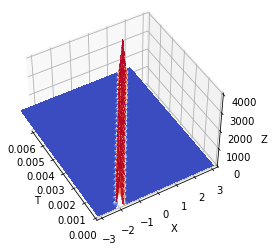

In [3]:
N = 256
x = (2.*np.pi/N)*np.arange(-N/2,N/2).reshape(N,1) # Space discretization
s, shift = 25.**2., 2. # Initial data is a soliton
y0 = (3.*s*np.cosh(.5*(sqrt(s)*(x+shift)))**(-2.)).reshape(N,)
# Solves the ODE.
max_t = .0075
dt = .02*N**(-2.)

k = np.concatenate(( np.arange(0,N/2),np.array([0]),np.arange(-N/2+1,0,1) )).reshape(N,)

ik3 = 1j*k**3.
def G_unscaled(t,y):
    out = -.5*1j*k*fft(ifft(y,axis=0)**2.,axis=0) + ik3*y
    return out

max_tsteps = int(round(max_t/dt))
y0 = fft(y0,axis=0)
T,Y = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)
# Using the variable stride, we step through the data,
# applying the inverse fourier transform to obtain u.
# These values will be plotted.
stride = int(np.floor((max_t/25.)/dt))
uvalues, tvalues = np.real(ifft(y0,axis=0)).reshape(N,1), np.array(0.).reshape(1,1)
for n in range(1,max_tsteps+1):
    if np.mod(n,stride) == 0:
        t = n*dt
        u = np.real( ifft(Y[n], axis=0) ).reshape(N,1)
        uvalues = np.concatenate((uvalues,np.nan_to_num(u)),axis=1)
        tvalues = np.concatenate((tvalues,np.array(t).reshape(1,1)),axis=1)


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=45., azim=150)
tv, xv = np.meshgrid(tvalues,x,indexing='ij')
surf = ax.plot_surface(tv,xv, uvalues.T, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
tvalues = tvalues[0]; ax.set_xlim(tvalues[0], tvalues[-1])
ax.set_ylim(pi, -pi); ax.invert_yaxis()
ax.set_zlim(0., 4000.)
ax.set_xlim(0., 0.006)
ax.set_xlabel('T'); ax.set_ylabel('X'); ax.set_zlabel('Z')
plt.show()

# Problem 2

Numerically solve the KdV equation on $[−π, π]$. This time we dene the initial
condition to be the superposition of two solitons,
$$u(x,t=0) = 3s_1\mathrm{sech}^2\left(\frac{\sqrt{s_1}}{2}(x+a_1)\right) + 3s_2\mathrm{sech}^2\left(\frac{\sqrt{s_2}}{2}(x+a_2)\right),
$$

where $s_1 = 25^2$
, $a_1 = 2$, and $s_2 = 16^2$
, $a_2 = 1$.
Solve on the time domain $[0, .0075]$. 
Plot the solution.

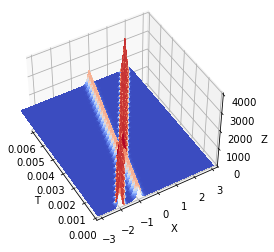

In [4]:
N = 256
x = (2.*np.pi/N)*np.arange(-N/2,N/2).reshape(N,1) # Space discretization
s1, a1, s2, a2 = 25.**2., 2, 16.**2, 1. # Initial data is a soliton
y0 = (3.*s1*np.cosh(.5*(sqrt(s1)*(x+a1)))**(-2.) + 3.*s2*np.cosh(.5*(sqrt(s2)*(x+a2)))**(-2.)).reshape(N,)
# Solves the ODE.
max_t = .0075
dt = .02*N**(-2.)

k = np.concatenate(( np.arange(0,N/2),np.array([0]),np.arange(-N/2+1,0,1) )).reshape(N,)

ik3 = 1j*k**3.
def G_unscaled(t,y):
    out = -.5*1j*k*fft(ifft(y,axis=0)**2.,axis=0) + ik3*y
    return out

max_tsteps = int(round(max_t/dt))
y0 = fft(y0,axis=0)
T,Y = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)

# Using the variable stride, we step through the data,
# applying the inverse fourier transform to obtain u.
# These values will be plotted.
stride = int(np.floor((max_t/25.)/dt))
uvalues, tvalues = np.real(ifft(y0,axis=0)).reshape(N,1), np.array(0.).reshape(1,1)
for n in range(1,max_tsteps+1):
    if np.mod(n,stride) == 0:
        t = n*dt
        u = np.real( ifft(Y[n], axis=0) ).reshape(N,1)
        uvalues = np.concatenate((uvalues,np.nan_to_num(u)),axis=1)
        tvalues = np.concatenate((tvalues,np.array(t).reshape(1,1)),axis=1)


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=45., azim=150)
tv, xv = np.meshgrid(tvalues,x,indexing='ij')
surf = ax.plot_surface(tv,xv, uvalues.T, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
tvalues = tvalues[0]; ax.set_xlim(tvalues[0], tvalues[-1])
ax.set_ylim(pi, -pi); ax.invert_yaxis()
ax.set_zlim(0., 4000.)
ax.set_xlim(0., 0.006)
ax.set_xlabel('T'); ax.set_ylabel('X'); ax.set_zlabel('Z')
plt.show()

# Problem 3

Consider again equation (19.2). The linear term in this equation is $ik^3Y$ . This
term contributes much of the exponential growth in the ODE, and responsible for how short
the time step must be to ensure numerical stability. Make the substitution $Z = e^{−ik^3t}Y$ and
find a similar ODE for Z. Use the resulting equation to solve the previous problem and plot the solution.

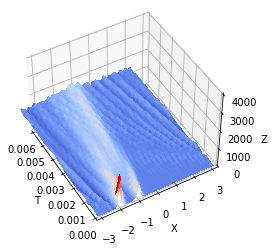

In [17]:
N = 256
x = (2.*np.pi/N)*np.arange(-N/2,N/2).reshape(N,1) # Space discretization
s1, a1, s2, a2 = 25.**2., 2, 16.**2, 1. # Initial data is a soliton
y0 = (3.*s1*np.cosh(.5*(sqrt(s1)*(x+a1)))**(-2.) + 3.*s2*np.cosh(.5*(sqrt(s2)*(x+a2)))**(-2.)).reshape(N,)
# Solves the ODE.
max_t = .0075
dt = .02*N**(-2.)

k = np.concatenate(( np.arange(0,N/2),np.array([0]),np.arange(-N/2+1,0,1) )).reshape(N,)

ik3 = 1j*k**3.
def G_unscaled(t,y):
    out = -.5*1j*k*np.exp(-ik3*t)*fft(ifft(y*np.exp(-ik3*t)**2.,axis=0)**2.,axis=0)
    return out

max_tsteps = int(round(max_t/dt))
y0 = fft(y0,axis=0)
T,Z = RK4(G_unscaled, y0, t0=0, t1=max_t, n=max_tsteps)
Y = np.exp(T.reshape((-1, 1)) * ik3) * Z

# Using the variable stride, we step through the data,
# applying the inverse fourier transform to obtain u.
# These values will be plotted.
stride = int(np.floor((max_t/25.)/dt))
uvalues, tvalues = np.real(ifft(y0,axis=0)).reshape(N,1), np.array(0.).reshape(1,1)
for n in range(1,max_tsteps+1):
    if np.mod(n,stride) == 0:
        t = n*dt
        u = np.real( ifft(Y[n], axis=0) ).reshape(N,1)
        uvalues = np.concatenate((uvalues,np.nan_to_num(u)),axis=1)
        tvalues = np.concatenate((tvalues,np.array(t).reshape(1,1)),axis=1)


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(elev=45., azim=150)
tv, xv = np.meshgrid(tvalues,x,indexing='ij')
surf = ax.plot_surface(tv,xv, uvalues.T, rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=False)
tvalues = tvalues[0]; ax.set_xlim(tvalues[0], tvalues[-1])
ax.set_ylim(pi, -pi); ax.invert_yaxis()
ax.set_zlim(0., 4000.)
ax.set_xlim(0., 0.006)
ax.set_xlabel('T'); ax.set_ylabel('X'); ax.set_zlabel('Z')
plt.show()